#**Using Python libraries for Handling WaPOR Data**
#Notebook 5: Calculating and visualising zonal statistics for multiple seasons
In this Notebook we will show you how to run a script developed for the WaPOR project that calculates zonal statistics for multiple seasons. And to visualise the results (TBP over AETI).   
The steps are:
1. Install and load necessary Python Libraries to manage raster files
2. Create DataFrame of zonal statistics of AETI and TBP for each farm and each season
3. Merge DataFrames and visualise scatterplots of AETI and TBP.
4. Exercises (needed for MOOC quiz)


**Data needed**:

For the exercises of the [MOOC Python for geospatial analyses using WaPOR data](https://ocw.un-ihe.org/course/view.php?id=272) you can use the following data:

* **Area**: Farm boundaries in Wad Helal irrigation block. For this exercise you need a .shp file of the WH_fields.geojson used in the previous notebook.

* **TIFF files**: seasonal TIFF files of TBP and AETI saved after running [Notebook 3 : Temporal data aggregation](https://github.com/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N02_Temporal_Aggregation.ipynb)

Save these files on google drive in a folder `Python_mooc` in the main drive.

## Step 1 - Import modules/libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rioxarray --quiet
!pip install rasterstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 41.3 MB/s eta 0:00:00


In [ ]:
import os                                 # a module for interacting with the operating system
import sys
import glob                               # used to retrieve files/pathnames matching a specified pattern
import re                                 # re sub() module can be used to replace substring
import rioxarray as rio
import pandas as pd                       # to store and manipulate tabular data in rows of observations and columns of variables
import numpy as np                        # stands for 'Numerical Python, is a python library used for scientific computing with arrays
import calendar
import datetime
from matplotlib import pyplot as plt      # is a plotting library used for 2D graphics in python
from osgeo import gdal
from osgeo import osr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats

In [ ]:
# define seasons
season_periods = {
    'season1': {'SOS': '2020-10-01', 'EOS': '2021-04-30'},
    'season2': {'SOS': '2021-10-01', 'EOS': '2022-04-30'},
    'season3': {'SOS': '2022-10-01', 'EOS': '2023-04-30'}
}

# Step 2 - Calculate zonal Statistics

The following scripts load the TBP seasonal data you saved from the Notebook 03 exercises (first Code cell) and calculates the zonal statistics for each farm (second Code cell). Check if the .xlxs file is created in your folder. Adapt the first Code cell to calculate zonal statistics for seasonal AETI by running both scripts.

**NOTE**: The file for the farms in this script is a .shp file. Create a .shp file from the geojson file in QGIS first

In [ ]:
folder_path = '/content/drive/MyDrive/Python_mooc/Data/TBP_season'                # path to the folder with raster files
shapefile_path = "/content/drive/MyDrive/Python_mooc/Data/fields/WH_fields.shp"       # path to shapefile
output_path = '/content/drive/MyDrive/Python_mooc/Data'                            # path to the output folder
output_file = 'TBP_per_field.xlsx'                                              # name of the output file

In [ ]:
def extract_identifier_from_filename(filename):
    parts = filename.split('_')  # Split by underscore
    date_part = parts[0]  # Combine the date parts
    return date_part.rstrip('.tif')

# Load shapefile
gdf = gpd.read_file(shapefile_path)

# Check and remove any rows with None geometries
gdf = gdf.dropna(subset=['geometry'])
if gdf['geometry'].isnull().any():
    print("Warning: Still found None geometries after filtering.")
else:
    print("All None geometries have been successfully filtered out.")

results_gdf = gdf.copy()

# Find all TIFF files in the folder
tif_files = glob.glob(os.path.join(folder_path, "*.tif"))
print(f"Found {len(tif_files)} TIFF files to process.")

# Process each TIFF file
for tif_file in tif_files:
    try:
        # Extract identifier from filename
        identifier = extract_identifier_from_filename(os.path.basename(tif_file))

        # Calculate zonal statistics for mean
        stats = zonal_stats(gdf, tif_file, stats="mean")

        # Extract mean values and assign to new column in DataFrame
        means = [stat['mean'] if stat else None for stat in stats]
        results_gdf[identifier] = means

    except Exception as e:
        print(f"Failed to process {tif_file}: {e}")
        continue

# Ensure the output directory exists
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Save the results to an Excel file, excluding the geometry column for easier viewing
results_gdf.drop(columns=['geometry']).to_excel(os.path.join(output_path, output_file), index=False)
print(f"Mean zonal statistics by date/identifier saved to {os.path.join(output_path, output_file)}")


Exercise:

View the data frame (what are the attributes of these files?)

Obtain values for farm number for each season


In [ ]:
# use pandas to read .xls file


# write code to extract data



# Step 3 - Plot results

We now want to create a scatter plot and therefore we have to merge the two files, which is done with the script below.

In [ ]:
aeti_data = pd.read_excel('/content/drive/MyDrive/Python_mooc/Data/AETI_per_field.xlsx')     ## path to AETI excel file
agbm_data = pd.read_excel('/content/drive/MyDrive/Python_mooc/Data/TBP_per_field.xlsx')     ## path to TBP excel file
merged_data = pd.merge(aeti_data, npp_data, on='id')


Exercise:

How many attributes does this new file have?  


In [ ]:
# list attributes


The following script creates one scatterplot with the AETI in the x-axis and TBP on the y-axis with each season presented using different colors.

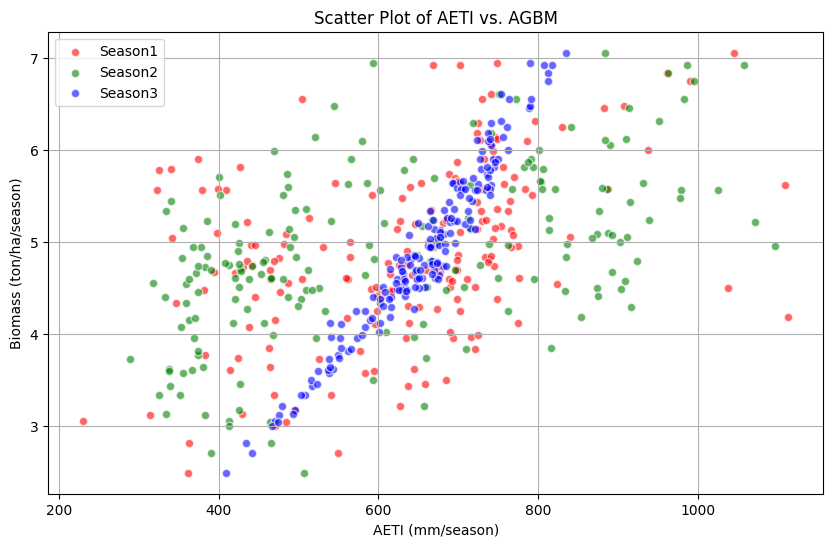

In [ ]:
# Plotting the scatter plot all in one figure
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['AETIseason1'], merged_data['TBPseason1'], alpha=0.6, edgecolors='w', color='red', label='Season1')
plt.scatter(merged_data['AETIseason2'], merged_data['TBPseason2'], alpha=0.6, edgecolors='w', color='green', label='Season2')
plt.scatter(merged_data['AETIseason3'], merged_data['TBPseason3'], alpha=0.6, edgecolors='w', color='blue', label='Season3')
plt.legend()
plt.title('Scatter Plot of AETI vs. TBP')
plt.xlabel('AETI (mm/season)')
plt.ylabel('Biomass Production (ton/ha/season)')
plt.grid(True)
plt.show()


If you want to create separate scatterplots for each season you have to create a `for` loop, as you can see below.

We also added a line to save the graph, can you find it? If you want to save the previous graph, how would you do this? Share your graph in the discussion forum. Add your name so we know you have mastered the materials.

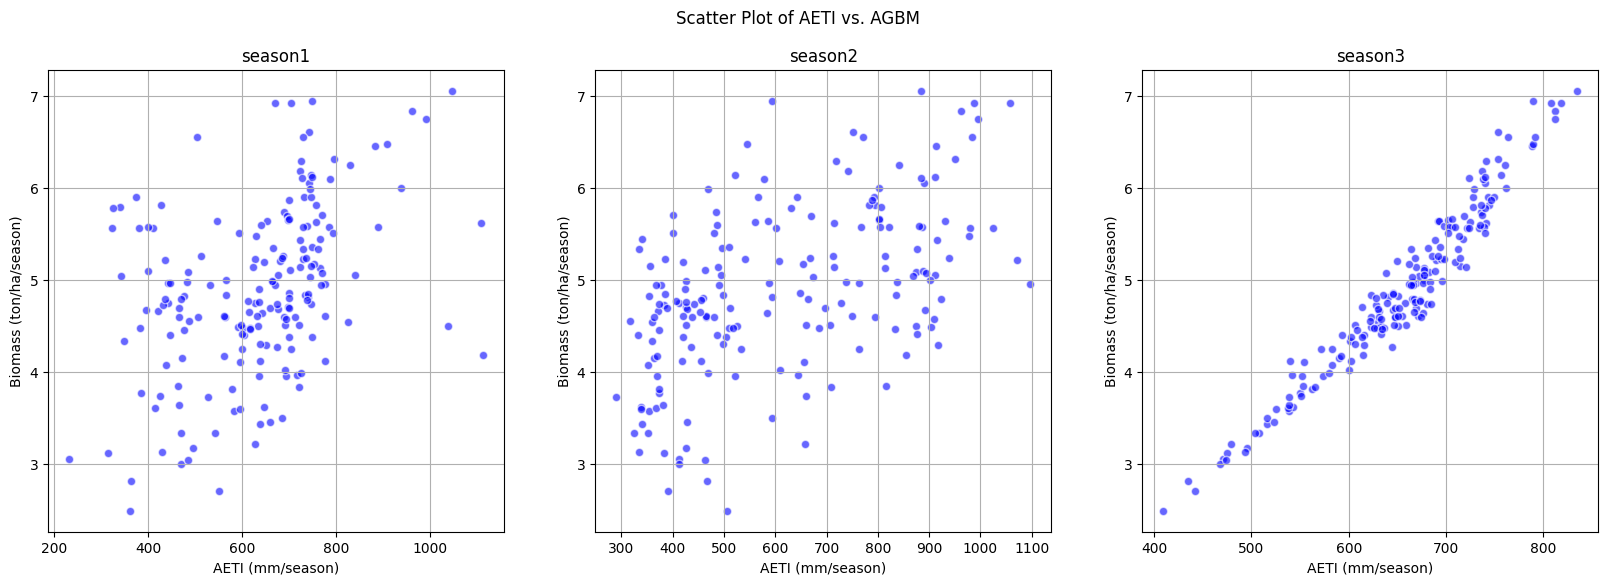

In [ ]:
# Plotting the scatter plot in separate figures
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(20, 6))
for i,season in enumerate(season_periods):
  axs[i].scatter(merged_data[f'AETI{season}'], merged_data[f'TBP{season}'], #name columns
                 alpha=0.6, edgecolors='w', color='blue') #
  axs[i].set_title(season)

  axs[i].set_xlabel('AETI (mm/season)')
  axs[i].set_ylabel('Biomass (ton/ha/season)')
  axs[i].grid(True)
plt.suptitle('Scatter Plot of AETI vs. TBP')
plt.savefig('/content/drive/MyDrive/Python_mooc/Data/AETIvsNPP.png') # saves the graphs
plt.show()


Excercise: Season 3 has a much stronger correlation between AETI and TBP compared to the other two seasons. What could be the reason for this?

1. The weather was better in season 3 compared to the other seasons
2. The crop type was consistent in season 3 (all fields were cropped with Wheat)
3. Irrigation water application was more uniform in season 3
4. Cropping season in season 1 and 2 was not well defined

Note down your answer, you need it in the MOOC quiz

BONUS: Add columns of seasonal water productivity to the DataFrame.


BONUS: Can you make a scatter plot for season 3 with each tertiary unit visualised with different colors? Share your result with us in the discussion forum.